ADS 509 Sentiment Assignment
This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard.

General Assignment Instructions
These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the Google Python Style Guide. If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential import statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. Make sure to answer every question marked with a Q: for full credit.

# Data Input

In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

import re
from string import punctuation

from nltk.tokenize import word_tokenize 


# Read in the lyrics data

In [2]:
# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = set(stopwords.words("english"))

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.UNICODE_EMOJI : 
    for em in emoji.UNICODE_EMOJI[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    num_tokens= len(tokens)
    unique_tokens = set(tokens)
    num_unique_tokens = len(unique_tokens)
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = len("".join(tokens))

    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")    
    
    return(0)

def is_emoji(s):
    return(s in all_language_emojis)

def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if is_emoji(ch)]

    return(len(emojis) > 0)

def remove_stop(tokens) :
    # modify this function to remove stopwords
    return set(tokens)-sw

def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    return re.split('\s+',text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

In [3]:
data_location = "C:\\Users\\trist\\OneDrive\\Desktop\\Freelance\School\\M1 Results\\" # change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

# # Read in the twitter data

In [4]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3,)

twitter_data['artist'] = "cher"

twitter_data.fillna(" ")

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,,1302,1014,,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,1496463006451974150,,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,gallionjenna,J,3366479914,,752,556,csu,cher
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher
...,...,...,...,...,...,...,...,...
3994798,tija15,Tija,556744001,,3,48,,cher
3994799,Hopplosa,Beea,132963903,Strägnäs,7,165,En IQ befriad brud från Strängnäs,cher
3994800,shazza280,Sharren Dalton,556598821,,138,227,,cher
3994801,pinchechemo1,Ivan Cruces,88285095,CDMX,258,1410,Un ente más en esta sociedad!,cher


In [5]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

# Read in the lyrics data

In [7]:
import pandas as pd
from collections import namedtuple
import os

# Read Lyrics
def read_lyrics_from_artist_folder(artist):

    artist_files = os.listdir("lyrics/" + artist)
    artist_files = [f for f in artist_files if 'txt' in f or 'csv' in f or 'tsv' in f]
    lyrics_tuples = []
    for f_name in artist_files : 
        with open("lyrics/" + artist + "/" + f_name) as infile : 
            song = re.split('.txt',f_name)
            contents = infile.read()
            lyrics_tuples.append((artist,song[0],contents))
            # lyrics_dict[artist][song[0]]=contents
    return lyrics_tuples

lyrics_list = []

# read lyrics for each artists and add to list
for artist in ['cher','robyn']:
    lyrics_list+=read_lyrics_from_artist_folder(artist)

lyrics_data = pd.DataFrame(lyrics_list,columns=['artist','song','lyrics'])

In [8]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

lyrics_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=lyrics_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=lyrics_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len)

print(twitter_data.head)
print(lyrics_data.head)

<bound method NDFrame.head of          screen_name          name                   id        location  \
0             hsmcnp  Country Girl             35152213             NaN   
1         horrormomy          Jeny   742153090850164742           Earth   
2       anju79990584          anju  1496463006451974150             NaN   
3       gallionjenna             J           3366479914             NaN   
4            bcscomm       bcscomm             83915043  Washington, DC   
...              ...           ...                  ...             ...   
358367     jakegiles    Jake Giles             19725102              LA   
358368    axelbluhme   Axel Bluhme             19573759              DK   
358369   RayRayRay27    Rachael :)             19919217          Oldham   
358370     bhandberg  Ben Handberg             12642462          Sydney   
358371    takemeback     Christine             15022058      New Jersey   

        followers_count  friends_count  \
0                  1302    

# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

In [9]:
# Read in the positive and negative words and the 
# tidytext sentiment. Store these so that the positive 
# words are associated with a score of +1 and negative words 
# are associated with a score of -1. You can use a dataframe or a  
# dictionary for this. 

# Used a DF

# Reading in Postive
pw_df = pd.read_csv("./positive-words.txt",header=None,skiprows=34,names=['word']) 
pw_df['sentiment'] = 'positive' 
pw_df['score'] = 1 
 

# Reading in Negative
nw_df = pd.read_csv("./negative-words.txt",header=None,skiprows=34,names=['word'],encoding='latin-1')
nw_df['sentiment'] = 'negative' 
nw_df['score'] = -1 
 
# Readying in Tidy
tt_df = pd.read_csv("./tidytext_sentiments.txt",sep="\t") 

# Sentiment Analysis on Songs

In [10]:
# Going to count how many postive or negative words there are and cast to dict

word_dict = {} 
pos_score = 1 
neg_score = -1 
# Adding the positive words to the dictionary 
for word in pw_df['word'].tolist(): word_dict[word] = pos_score 
# Adding the negative words to the dictionary 
for word in nw_df['word'].tolist(): word_dict[word] = neg_score

In [11]:
# Create sentiment_score function
# ss = Sentiment_score
def sentiment_score(text): 
  ss = 0 
  b_o_w = word_tokenize(text.lower())  
  for word in b_o_w: 
    if word in word_dict: 
      ss += word_dict[word] 
  return ss / len(b_o_w) 

In [12]:
lyrics_data['Sentiment_Score'] = lyrics_data['lyrics'].apply(sentiment_score) 

<AxesSubplot:title={'center':'Sentiment_Score'}, xlabel='[artist]'>

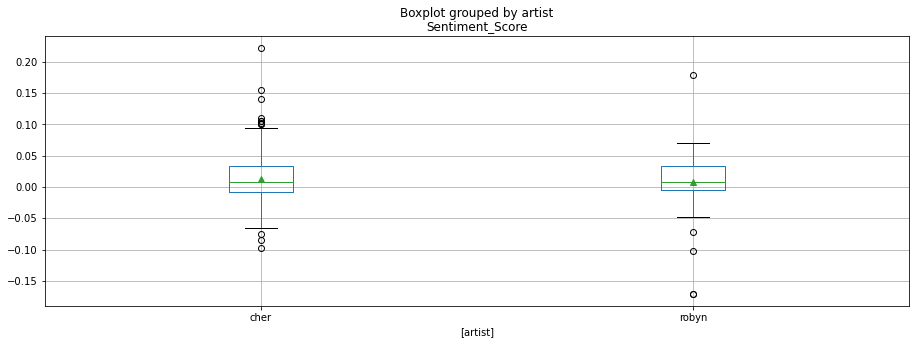

In [13]:
lyrics_data[['Sentiment_Score','artist']].boxplot(by='artist',figsize=(15,5),showmeans=True) 

## Q: Overall, which artist has the higher average sentiment per song?

## A: Cher has the higher average sentiment per song slightly.

## Q: For your first artist, what songs have the highest and lowest sentiments? Print those songs to the screen

In [14]:
lyrics_data[lyrics_data['artist']=='cher'].sort_values(by=['Sentiment_Score']).iloc[[0,-1]]


,artist,song,lyrics,tokens,num_tokens,Sentiment_Score
42,cher,cher_crymyselftosleep,"""Cry Myself To Sleep""\n\n\n\nEvery night, I la...","{, bed, sleep, linger, lies, nothing, know, he...",24,-0.097222
181,cher,cher_mylove,"""My Love""\n\n\n\nWhen I go away\nI know my hea...","{hold, , go, say, ask, mewhoa, find, know, nev...",29,0.222222


## Q: For your second artist, what songs have the highest and lowest sentiments? Print those songs to the screen

In [15]:
lyrics_data[lyrics_data['artist']=='robyn'].sort_values(by=['Sentiment_Score']).iloc[[0,-1]] 

,artist,song,lyrics,tokens,num_tokens,Sentiment_Score
342,robyn,robyn_dontfuckingtellmewhattodo,"""Don't Fucking Tell Me What To Do""\n\n\n\nMy d...","{, managers, shoppings, go, landlords, sleep, ...",41,-0.170354
380,robyn,robyn_loveisfree,"""Love Is Free""\n\n\n\nFree\nLove is free, baby...","{ugly, , mutter, rubber, x8, lo, digo, boom, l...",49,0.179894


## Q: Plot the distributions of the sentiment scores for both artists. You can use  seaborn  to plot densities or plot histograms in matplotlib.

array([<AxesSubplot:title={'center':'cher'}>,
       <AxesSubplot:title={'center':'robyn'}>], dtype=object)

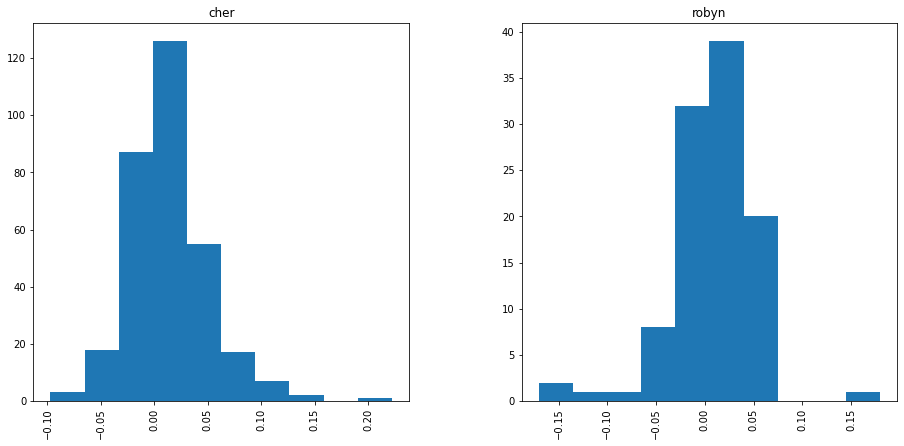

In [16]:
# Plotting histograms by artists
kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)

lyrics_data[['Sentiment_Score','artist']].hist(by='artist',figsize=(15,7)) 

# Sentiment Analysis on Twitter Descriptions

# Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter
# descriptions of their followers. The average sentiment can just be the total score divided by number of followers.

In [17]:
## Pulled csv for emojis from: https://github.com/pan-webis-de/martinc17/blob/master/word_lists/Emoji_Sentiment_Data_v1.0.csv

In [18]:
emoji_df = pd.read_csv("Emoji_Sentiment_Data.csv") 
emoji_df['pos'] = emoji_df['Positive']/emoji_df['Occurrences'] 
emoji_df['neg'] = emoji_df['Negative']/emoji_df['Occurrences']

In [19]:
emoji_dict = {} 
pos_score = 1 
neg_score = -1 
neural_score = 0 
 
# Adding the emojies to the emoji dict if they are pos, neg, or neutral
for idx,emo in enumerate(emoji_df['Emoji'].tolist()): 
  if emoji_df['pos'][idx] > emoji_df['neg'][idx]: 
    emoji_dict[emo] = pos_score 
  elif emoji_df['pos'][idx] < emoji_df['neg'][idx]: 
    emoji_dict[emo] = neg_score 
  else: 
    emoji_dict[emo] = neural_score

In [20]:
# Function for parsing emojis
all_language_emojis = set()

for country in emoji.UNICODE_EMOJI : 
    for em in emoji.UNICODE_EMOJI[country] : 
        all_language_emojis.add(em)

def is_emoji(s):
    return(s in all_language_emojis)

In [21]:
def is_emoji(text): 
  return_list = []

  for s in str(text):
    if s in emoji.UNICODE_EMOJI['en'].keys():
      return_list.append(s)

  # return_list = [s for s in text if s in emoji.UNICODE_EMOJI['en']]
  return return_list

def emoji_sentiment_score(text): 
  sentiment_score = 0 
  b_o_e = is_emoji(text) 
  if b_o_e: 
    for emo in b_o_e: 
      if emo in emoji_dict: 
        sentiment_score += emoji_dict[emo] 
    return sentiment_score / len(b_o_e) 
  else: 
    return None

twitter_data['emoji_Sentiment_Score'] = twitter_data['description'].apply(emoji_sentiment_score) 

In [22]:
twitter_data.head(5)

,screen_name,name,id,location,followers_count,friends_count,description,artist,tokens,num_tokens,emoji_Sentiment_Score
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher,{nan},1,NaN
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher,"{𝙿𝚛𝚘𝚞𝚍, 𝚋𝚞𝚗𝚜, 𝚘𝚏, 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛, 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜, 𝚖𝚎𝚜𝚜𝚢}",6,NaN
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher,"{163㎝／愛かっぷ💜26歳🍒, 工〇好きな女の子💓, フォローしてくれたらdmします🧡}",3,0.75
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher,{csu},1,NaN
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher,"{wibsilergmailcom, past, writer, pro, pr, bcsc...",17,NaN


In [23]:
twitter_data.dropna(subset=['emoji_Sentiment_Score']).groupby('artist')['emoji_Sentiment_Score'].mean()

artist
cher     0.705995
robyn    0.701168
Name: emoji_Sentiment_Score, dtype: float64

In [24]:
def is_emoji(text): 
  return_list = []

  for s in str(text):
    if s in emoji.UNICODE_EMOJI['en'].keys():
      return_list.append(s)

  # return_list = [s for s in text if s in emoji.UNICODE_EMOJI['en']]
  return return_list

twitter_data['description_emojis'] = twitter_data['description'].apply(is_emoji) 

# Q: Which positive emoji is the most popular for each artist? Which negative emoji?

In [59]:
from collections import Counter
twitter_data.head(5)

most_common_emoji_dict = {}

for this_artist in artist_files.keys():
    full_emoji_list = []

    for row in twitter_data.itertuples():
        # print(type(twitter_data['description_emojis']))
        
        this_list = twitter_data['description_emojis'].tolist()
        print(this_list)
        full_emoji_list+=this_list
        

    this_counter=Counter(full_emoji_list)
    most_common_emoji_dict[artist]=this_counter.most_common()
    # print(counters_dict[artist])
